In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import ipywidgets as widgets
from ipywidgets import VBox, HBox, interactive
import math
import matplotlib.image as img
import cv2
from IPython.display import clear_output, display
from tkinter import Tk, filedialog
from datetime import datetime
import seaborn as sns
import imageio

darauf verweisen wäre die einfachste Option. 

'This notebook consists of the following classes:
  
    
    class main
    class subjects
    class session
    class bottom_cam
    class maze corner
    class clean_df
    class df_functions
    class stats
    
    class gui
        class main_gui
        class subject_gui
        class clean_df_gui
        class select_functions
        
    class maze_corner_gui       
    class stats_gui


Name all of your .csv/.mp4/.avi files strictly like this: 

                        210_F1-83_220518_OTT_bottom
                        211_F3-04_211123_OTR_top

                        Line_ID_Date_Paradigm_Camera   
                    
Your framerate should not have decimal places.

In [2]:
class main: 
    """Main object contains overview over all files, subjects and common variable over a folder of files as specified by the path."""
    l_maze_corners_bc = []
    l_maze_corners_tc = []

    def __init__(self, path = "PATH", dict_cams_used = {"bottom_cam": True, "top_cam": False, "side_cam": False}, gui = False):
        #creates common variables
        main.path = path
        main.dict_cams_used = dict_cams_used
        main.gui = gui
        if main.path != "PATH":
            self.all_information_given()
        
    def all_information_given(self):
        #creates objects for all of the files in the chosen folder
        main.l_session_IDs = np.unique(np.array([file for file in set ([elem[15:-50] for elem in os.listdir(self.path) if elem.endswith('CatwalkMay25shuffle1_90000.csv')])])).tolist()
        main.l_sessions = [session(session_ID) for session_ID in self.l_session_IDs]
        main.l_subject_IDs = np.unique(np.array([session.subject_ID for session in self.l_sessions])).tolist()
        main.l_subjects = [subject(subject_ID) for subject_ID in self.l_subject_IDs]
            
    def subjects_to_groups(self, subject_group_dict, l_groups):
        #provides each subject a subject_ID as in subject_group_dict
        if main.all_files_there:
            main.l_groups = l_groups
            for subject in range(len(self.l_subjects)):
                self.l_subjects[subject].group_ID = subject_group_dict[self.l_subjects[subject].subject_ID]
                print(self.l_subjects[subject].group_ID)
            if main.gui==False:
                #branch that will be used if gui-less usage is chosen
                self.get_maze_corners()

    def get_maze_corners(self):
        #if top or bottom cam are used, this function creates the maze_corner annotation
        if self.all_files_there:
            main.l_maze_corners = [session.bc.mc for session in self.l_sessions]
            if gui.displayed == False:
                display(gui.main_tab)
                gui.displayed = True
            maze_corner_gui()
        else:
            self.get_processed_dfs()
                   
    def get_processed_dfs(self, DLC_likelihood_threshold = 0.90):
        #processes the dataframes
        main.dict_bodyparts = {}#wird zukünftig ersetzt durch class bodypart 
        if self.dict_cams_used["bottom_cam"]:
            for session in self.l_sessions:
                session.bc.processed_df = clean_df(session.bc, DLC_likelihood_threshold).df 
        
    def execute_functions(self, dict_selected_functions = {"Anxiety": False, "Parkinson": False, "Catwalk": True}):
        #calculates the target variables as chosen in dict_selected_functions
        self.get_col_in_master_df_and_main_dataframe(dict_selected_functions)
        
        for subject in self.l_subjects:
            for session in subject.l_sessions:
                session.master_df = df_functions(subject, session, dict_selected_functions).master_df
                self.append_session_to_d_data(subject, session, dict_selected_functions)
                
        self.analysis_dataframe = pd.DataFrame(data=self.analysis_data)
        main.coverage_dict = {}
        for col in self.analysis_dataframe.columns:
            if col != "Session":
                main.coverage_dict[col] = self.analysis_dataframe.loc[:, col].mean()
        
        main.dataframe = pd.DataFrame(data = self.d_data)
        if gui.displayed == False:
            display(gui.main_tab)
            gui.displayed = True
            
        stats_gui(dict_selected_functions)
        
    def get_col_in_master_df_and_main_dataframe(self, dict_selected_functions):
        #creates the master and main dataframe
        self.analysis_data = []
        main.d_data = {'subject_ID': [], 'group_ID': [], 'paradigm': [], }
        main.col_in_master_df = [('subject_ID', ('subject_ID', '')),
                    ('group_ID', ('group_ID', '')),
                    ('paradigm', ('paradigm', '')),
                    ('time', ('time', '')),
                    ('exclude', ('all', 'exclude')), 
                    ('CenterOfGravity_x_norm_cm', ('CenterOfGravity', 'x_norm_cm')),
                    ('CenterOfGravity_y_norm_cm', ('CenterOfGravity', 'y_norm_cm')),                    
                    ('CenterOfGravity_rolling_speed_px_per_s', ('CenterOfGravity', 'rolling_speed_px_per_s'))]
        
        d_data_cat = {'mean_angle_secondfinger_hindpawright_hindkneeright' : [], 
                  'mean_angle_secondfinger_hindpawleft_hindkneeleft' : [], 
                  'mean_angle_hindpawright_hindkneeright_CoG': [], 
                  'mean_angle_hindpawleft_hindkneeleft_CoG': [],
                  'mean_angle_hindpawleft_secondfinger_fifthfinger': [],
                  'mean_angle_hindpawright_secondfinger_fifthfinger': [],
                  'mean_distance_hindpawrightsecondfinger_hindpawright': [], 
                  'mean_distance_hindpawleftsecondfinger_hindpawleft': [],
                  'mean_area_hindpawright': [], 
                  'mean_area_hindpawleft': [], 
                  'mean_angle_CoG_HindPawRight_FifthFinger': [],
                  'mean_angle_CoG_HindPawLeft_FifthFinger': [],
                  'mean_angle_bodyaxis_HindPawLeft': [],
                  'mean_angle_bodyaxis_ForePawLeft': [],
                  'mean_angle_bodyaxis_HindPawRight': [],
                  'mean_angle_bodyaxis_ForePawRight': [],
                  'mean_hind_stance': [],
                  'mean_fore_stance': [],
                     } 
        
        main.d_data = self.d_data | d_data_cat
        main.col_in_master_df.extend([("angle_secondfinger_hindpawright_hindkneeright", ("angle_secondfinger_hindpawright_hindkneeright", "")), 
                                      ("angle_secondfinger_hindpawleft_hindkneeleft", ("angle_secondfinger_hindpawleft_hindkneeleft", "")),
                                      ("angle_hindpawright_hindkneeright_CoG", ("angle_hindpawright_hindkneeright_CoG", "")),
                                      ("angle_hindpawleft_hindkneeleft_CoG", ("angle_hindpawleft_hindkneeleft_CoG", "")),
                                      ("angle_hindpawright_secondfinger_fifthfinger", ("angle_secondfinger_hindpawright_fifthfinger", "")),
                                      ("angle_hindpawleft_secondfinger_fifthfinger", ("angle_secondfinger_hindpawleft_fifthfinger", "")),
                                      ("distance_secondfinger_hindpawright", ("distance_secondfinger_hindpawright", "")),
                                      ("distance_secondfinger_hindpawleft", ("distance_secondfinger_hindpawleft", "")),
                                      ("area_HindPawRight", ("area_HindPawRight", "")),
                                      ("area_HindPawLeft", ("area_HindPawLeft", "")),
                                      ("angle_CoG_HindPawRight_FifthFinger", ("angle_CoG_HindPawRight_FifthFinger", "")),
                                      ("angle_CoG_HindPawLeft_FifthFinger", ("angle_CoG_HindPawLeft_FifthFinger", "")),
                                      ("angle_bodyaxis_ForePawRight", ("angle_bodyaxis_ForePawRight", "")),
                                      ("angle_bodyaxis_ForePawLeft", ("angle_bodyaxis_ForePawLeft", "")),
                                      ("angle_bodyaxis_HindPawRight", ("angle_bodyaxis_HindPawRight", "")),
                                      ("angle_bodyaxis_HindPawLeft", ("angle_bodyaxis_HindPawLeft", "")),
                                      ("hind_stance", ("hind_stance", "")),
                                      ("fore_stance", ("fore_stance", "")),
                                     ])

    def append_session_to_d_data(self, subject, session, dict_selected_functions): 
        #appends data of each session to a dict containing all sessions
        wall_end_position = 35 #in cm

        self.d_data['subject_ID'].append(session.subject_ID)
        self.d_data['group_ID'].append(subject.group_ID)
        self.d_data['paradigm'].append(session.paradigm)         
                          
        self.d_data['mean_angle_secondfinger_hindpawright_hindkneeright'].append(session.master_df['angle_hindpawright_hindkneeright_CoG'].mean())
        self.d_data['mean_angle_secondfinger_hindpawleft_hindkneeleft'].append(session.master_df['angle_hindpawleft_hindkneeleft_CoG'].mean())
        self.d_data['mean_angle_hindpawright_hindkneeright_CoG'].append(session.master_df['angle_secondfinger_hindpawright_hindkneeright'].mean())
        self.d_data['mean_angle_hindpawleft_hindkneeleft_CoG'].append(session.master_df['angle_secondfinger_hindpawleft_hindkneeleft'].mean())
        self.d_data['mean_angle_hindpawleft_secondfinger_fifthfinger'].append(session.master_df['angle_hindpawleft_secondfinger_fifthfinger'].mean())
        self.d_data['mean_angle_hindpawright_secondfinger_fifthfinger'].append(session.master_df['angle_hindpawright_secondfinger_fifthfinger'].mean())
        self.d_data['mean_distance_hindpawrightsecondfinger_hindpawright'].append(session.master_df['distance_secondfinger_hindpawright'].mean())
        self.d_data['mean_distance_hindpawleftsecondfinger_hindpawleft'].append(session.master_df['distance_secondfinger_hindpawleft'].mean())
        self.d_data['mean_area_hindpawright'].append(session.master_df['area_HindPawRight'].mean())
        self.d_data['mean_area_hindpawleft'].append(session.master_df['area_HindPawLeft'].mean())
        self.d_data['mean_angle_CoG_HindPawRight_FifthFinger'].append(session.master_df['angle_CoG_HindPawRight_FifthFinger'].mean())
        self.d_data['mean_angle_CoG_HindPawLeft_FifthFinger'].append(session.master_df['angle_CoG_HindPawLeft_FifthFinger'].mean())
        self.d_data['mean_angle_bodyaxis_ForePawRight'].append(session.master_df["angle_bodyaxis_ForePawRight"].mean())
        self.d_data['mean_angle_bodyaxis_HindPawRight'].append(session.master_df["angle_bodyaxis_HindPawRight"].mean())
        self.d_data['mean_angle_bodyaxis_ForePawLeft'].append(session.master_df["angle_bodyaxis_ForePawLeft"].mean())
        self.d_data['mean_angle_bodyaxis_HindPawLeft'].append(session.master_df["angle_bodyaxis_HindPawLeft"].mean())
        self.d_data["mean_fore_stance"].append(session.master_df["fore_stance"].mean())
        self.d_data["mean_hind_stance"].append(session.master_df["hind_stance"].mean())

        self.analysis_data.append(session.dict_analysis)
        
    def calculate_stats(self, output_path, l_selected_data_col_dict):
        #calls the stats class with inputs as chosen in the stats_gui
        for dict_stats in l_selected_data_col_dict:
            stats.total_count_stats(self, dict_stats["data_col"], dict_stats["independent_variable"], dict_stats["hue"], output_path)
            if "y_position" in dict_stats["data_col"]:
                stats.position_stats(self, dict_stats["data_col"], dict_stats["independent_variable"], dict_stats["hue"], output_path)

In [3]:
class subject(main):
    """creates an object representing an individual subject"""
    def __init__(self, subject_ID):
        self.subject_ID = subject_ID
        self.l_sessions = [session for session in main.l_sessions if session.subject_ID == self.subject_ID]
        self.l_paradigms = [session.paradigm for session in self.l_sessions]
        self.dict_date_paradigm = {session.date:session.paradigm for session in self.l_sessions}

In [4]:
class session(subject):
    """creates an object representing an individual session and checks, whether all the files are there"""
    def __init__(self, session_ID):
        self.session_ID = session_ID
        print(session_ID)
        self.paradigm = "None"
        if 'prä-OP1' in self.session_ID:
            self.paradigm = 'prä-OP1'
        elif 'prä-OP2'  in self.session_ID:
            self.paradigm  = 'prä-OP2'
        elif 'prä-OP3'  in self.session_ID:
            self.paradigm = 'prä-OP3'
        elif 'post-OP'  in self.session_ID:
            self.paradigm = 'post-OP'
        elif 'post1xIgG'  in self.session_ID or 'post-1xIgG' in self.session_ID:
            self.paradigm = 'post1xIgG'
        elif 'post3xIgG'  in self.session_ID:
            self.paradigm = 'post3xIgG'
        elif 'post6xIgG'  in self.session_ID:
            self.paradigm = 'post6xIgG'
        if self.paradigm == "None":
            print("File for session {} has to be renamed!".format(self.session_ID))
        self.date = datetime.strptime(self.session_ID[-6:], '%y%m%d')
        self.subject_ID = self.session_ID[0:6] 
        bc_csv = self.session_ID in set([elem[15:-50] for elem in os.listdir(main.path) if elem.endswith('CatwalkMay25shuffle1_90000.csv')])
        bc_mp4 = self.session_ID in set([elem[15:-4] for elem in os.listdir(main.path) if elem.endswith('.mp4')]) 
        
        
        main.all_files_there = True
        if bc_csv == False:
            print("Missing .csv file for session {} in {}!".format(self.session_ID, main.path))
            main.all_files_there = False
        elif bc_mp4 == False:
            print("Missing .mp4 file for session {} in {}!".format(self.session_ID, main.path))
            main.all_files_there = False
        mp4_file_list = [elem for elem in os.listdir(main.path) if elem.endswith('.mp4')]
        for n in range(len(mp4_file_list)):
            if session_ID in mp4_file_list[n]:
                bc_video_filename = main.path+mp4_file_list[n]
        csv_file_list = [elem for elem in os.listdir(main.path) if elem.endswith('CatwalkMay25shuffle1_90000.csv')]
        for n in range(len(csv_file_list)):
            if session_ID in csv_file_list[n]:
                bc_csv_filename = csv_file_list[n]
        bc_df = pd.read_csv(main.path + bc_csv_filename, skiprows=1, index_col=0, header=[0, 1])
        self.bc = bottom_cam(self.session_ID, bc_df, bc_video_filename)


In [5]:
class bottom_cam(session):
    """creates an object containing the data for bottom cam recording modality"""
    def __init__(self, session_ID, df, video_file_name):
        self.session_ID = session_ID
        self.df = df
        self.video_path = video_file_name 
        self.mc = maze_corners(self.video_path, self.session_ID)
        video = imageio.get_reader(self.video_path,  'ffmpeg')
        self.framerate = video.get_meta_data()["fps"]
        self.frame_number = video.count_frames()
        self.cam = "bottom_cam"

In [36]:
class clean_df(session):
    """creates an object that returns the cleaned dataframe after processing several functions"""
    maze_length_in_cm = 50
    maze_width_in_cm = 3
    
    def __init__(self, session_cam_object, threshold):        
        self.threshold = threshold
        self.framerate = session_cam_object.framerate
        self.results = session_cam_object.mc.results
        df = session_cam_object.df
        self.l_bodyparts = [elem[0] for elem in df.columns[::3]]
        main.dict_bodyparts[session_cam_object.cam] = self.l_bodyparts
        df = self.get_time(df)
        df[('all', 'exclude')] = False
        df = self.exclude_frames(df)
        df = self.normalize_coordinates(df)
        self.df = df
        
    def get_time(self, df):
        #appends the dataframe with an column time, calculated by index and framerate
        df['time'] = np.NaN
        df['time'] = df['EarRight'].index/self.framerate
        return df

    def exclude_frames(self, df):
        #excludes frames, where the likelihood is below a certain threshold
        for bodypart in self.l_bodyparts:
            df.loc[:, (bodypart, 'exclude')] = False
            df.loc[df[bodypart]['likelihood'] < self.threshold, (bodypart, 'exclude')] = True
            df.loc[df[('all', 'exclude')] == True, (bodypart, 'exclude')] = True
        return df
    
    def rotate(self, xy, theta):
        cos_theta, sin_theta = math.cos(theta), math.sin(theta)
        return(xy[0] * cos_theta + xy[1] * sin_theta, - xy[0] * sin_theta + xy[1] * cos_theta)
            #rotates clockwise

    def translate(self, xy, offset):
        return (xy[0] + offset[0], xy[1] + offset[1])


    def normalize_coordinates(self, df):
        #uses the functions rotate and translate to normalize the coordinates
        length = self.results['length']
        width = self.results['width']
        offset_to_standard = (-self.results['offset_x'], -self.results['offset_y'])
        offset_from_standard = (self.results['offset_x'], self.results['offset_y'])
        theta_to_standard = self.results['theta']

        length_in_px = length
        cm_per_px = self.maze_length_in_cm/length_in_px
            
        for bodypart in self.l_bodyparts:
            df[(bodypart, 'x_norm')] = self.rotate(self.translate((df[(bodypart,'x')], df[(bodypart,'y')]), offset_to_standard), theta_to_standard)[0]
            df[(bodypart, 'y_norm')] = self.rotate(self.translate((df[(bodypart,'x')], df[(bodypart,'y')]), offset_to_standard), theta_to_standard)[1]
            df[(bodypart, 'x_norm_cm')] = (df[(bodypart, 'x_norm')] * cm_per_px)
            df[(bodypart, 'y_norm_cm')] = (df[(bodypart, 'y_norm')] * cm_per_px)
            
        return df   

TypeError: __init__() takes 2 positional arguments but 4 were given

In [7]:
class df_functions(bottom_cam):
    """class that returns the dataframe appended with the chosen target variables after calling several functions and combines different recording modalities"""
    immobility_threshold = 16

    min_freezing_duration = 1

    TIME_OF_GAIT_BEFORE_DISRUPT = 0.5
    TARGET_TIME_GAIT_DISRUPTION = 0.2
    
    def __init__(self, subject, session, dict_selected_functions):
        #loops through the functions
        self.session = session
        self.subject = subject
        self.dict_selected_functions = dict_selected_functions
        self.session.dict_analysis = {}
        self.session.dict_analysis['Session'] = self.session.session_ID
        df = session.bc.processed_df
        self.l_bodyparts = main.dict_bodyparts["bottom_cam"]
        self.framerate = session.bc.framerate

        df = self.get_speed_and_rolling_speed(df)
        df = self.get_immobility(df)
        df = self.get_angle_finger_paw_knee_paw_knee_CoG(df)
        df = self.get_angle_finger_paw_finger(df)
        df = self.get_distance_secondfinger_pawbase(df)
        df = self.get_paw_area(df)
        df = self.get_angle_CoG_Paw_FifthFinger(df)
        df = self.get_angle_bodyaxis_paw_finger(df)
        df = self.get_stance_width(df)
        
        self.combined_df = self.add_metadata(df)
        self.master_df = self.get_master_df()
        
    def get_speed_and_rolling_speed(self, df):
        #calcualtes speed for the bodyparts
        for bodypart in self.l_bodyparts:
            df[(bodypart, 'speed_px_per_s')] = np.NaN
            df[(bodypart, 'rolling_speed_px_per_s')] = np.NaN

            # Limitation: since we have to exclude some frames, these calculations are not made frame by frame (yet for most)
            df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'speed_px_per_s')] = (((df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'x')].diff()**2                                                                                                        + df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'y')].diff()**2)**(1/2)) 
                                                                                                                             / df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), 'time'].diff())
            df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'rolling_speed_px_per_s')] = df.loc[(df[('all', 'exclude')] == False), (bodypart, 'speed_px_per_s')].rolling(5, min_periods=3, center=True).mean()
        return df
    
    def get_immobility(self, df):
        #checks for immobility
        for bodypart in self.l_bodyparts:
            # create 'immobility' column and set base value to false
            df.loc[ :, (bodypart, 'immobility')] = False
            df.loc[df[(bodypart,'rolling_speed_px_per_s')] < self.immobility_threshold, (bodypart, 'immobility')] = True
        return df
        
    def add_metadata(self, df):
        #adds metadata to the dataframe
        df['subject_ID'] = self.subject.subject_ID
        df['group_ID'] = self.subject.group_ID
        df['DateOfRecording'] = self.session.date
        df['paradigm'] = self.session.paradigm
        return df
    
    def get_master_df(self):
        #combines all the information into a master_df as specified by col_in_precessed_df
        d_for_master_df = {}
        for key, col_in_processed_df in main.col_in_master_df:
            d_for_master_df[key] = self.combined_df[col_in_processed_df].values

        master_df = pd.DataFrame(data=d_for_master_df)
        return master_df
        
    def get_angle_finger_paw_knee_paw_knee_CoG(self, df):
        df['angle_secondfinger_hindpawright_hindkneeright'] = np.NaN
        df['angle_secondfinger_hindpawleft_hindkneeleft'] = np.NaN
        df['angle_hindpawright_hindkneeright_CoG'] = np.NaN
        df['angle_hindpawleft_hindkneeleft_CoG'] = np.NaN
        
        #HindPawRightSecondFinger
        cy = df.loc[:, ('HindPawRightSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawRightSecondFinger', 'x_norm_cm')]
        #HindPawRight
        ay = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawRight', 'x_norm_cm')]
        #HindKneeRight
        by = df.loc[:, ('HindKneeRight', 'y_norm_cm')]
        bx = df.loc[:, ('HindKneeRight', 'x_norm_cm')]
        #angle_secondfinger_hindpawright_hindkneeright
        df_copy = df.copy()
        df_copy.loc[:, ('angle_secondfinger_hindpawright_hindkneeright')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_secondfinger_hindpawright_hindkneeright')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindKneeRight', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawright_hindkneeright')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindKneeRight', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("angle_secondfinger_hindpawright_hindkneeright", n)
        
        #HindPawRight
        cy = by
        cx = bx
        #HindKneeRight
        ay = ay
        ax = ax
        #CoG
        by = df.loc[:, ('CenterOfGravity', 'y_norm_cm')] 
        bx = df.loc[:, ('CenterOfGravity', 'x_norm_cm')] 
        #angle_hindpawright_hindkneeright_CoG      
        df_copy = df.copy()
        df_copy.loc[:, ('angle_hindpawright_hindkneeright_CoG')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_hindpawright_hindkneeright_CoG')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False) & (df[('HindKneeRight', 'exclude')] == False), ('angle_hindpawright_hindkneeright_CoG')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False) & (df[('HindKneeRight', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("angle_hindpawright_hindkneeright_CoG", n)
        
        
        
        #HindPawleftSecondFinger
        cy = df.loc[:, ('HindPawLeftSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawLeftSecondFinger', 'x_norm_cm')]
        #HindPawleft
        ay = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #HindKneeleft
        by = df.loc[:, ('HindKneeleft', 'y_norm_cm')]
        bx = df.loc[:, ('HindKneeleft', 'x_norm_cm')]
        #angle_secondfinger_hindpawleft_hindkneeleft
        df_copy = df.copy()
        df_copy.loc[:, ('angle_secondfinger_hindpawleft_hindkneeleft')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_secondfinger_hindpawleft_hindkneeleft')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindKneeleft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawleft_hindkneeleft'))]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindKneeleft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("angle_secondfinger_hindpawleft_hindkneeleft", n)
        
        
        #HindPawleft
        cy = by
        cx = bx
        #HindKneeleft
        ay = ay
        ax = ax
        #CoG
        by = df.loc[:, ('CenterOfGravity', 'y_norm_cm')] 
        bx = df.loc[:, ('CenterOfGravity', 'x_norm_cm')] 
        #angle_hindpawleft_hindkneeleft_CoG      
        df_copy = df.copy()
        df_copy.loc[:, ('angle_hindpawleft_hindkneeleft_CoG')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_hindpawleft_hindkneeleft_CoG')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False) & (df[('HindKneeleft', 'exclude')] == False), ('angle_hindpawleft_hindkneeleft_CoG')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False) & (df[('HindKneeleft', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("angle_hindpawleft_hindkneeleft_CoG", n)
        
        return df
    
    def get_angle_finger_paw_finger(self, df):
        df['angle_secondfinger_hindpawright_fifthfinger'] = np.NaN
        df['angle_secondfinger_hindpawleft_fifthfinger'] = np.NaN
        
        
        cy = df.loc[:, ('HindPawRightSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawRightSecondFinger', 'x_norm_cm')]
        #HindPawleft
        ay = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawRight', 'x_norm_cm')]
        #HindKneeleft
        by = df.loc[:, ('HindPawRightFifthFinger', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawRightFifthFinger', 'x_norm_cm')]
        #angle_secondfinger_hindpawleft_hindkneeleft
        df_copy = df.copy()
        df_copy.loc[:, ('angle_secondfinger_hindpawright_fifthfinger')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_secondfinger_hindpawright_fifthfinger')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawright_fifthfinger'))]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawright_fifthfinger')].shape[0]
        self.get_analysis_dict("angle_secondfinger_hindpawright_fifthfinger", n)
        
        cy = df.loc[:, ('HindPawLeftSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawLeftSecondFinger', 'x_norm_cm')]
        #HindPawleft
        ay = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #HindKneeleft
        by = df.loc[:, ('HindPawLeftFifthFinger', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawLeftFifthFinger', 'x_norm_cm')]
        #angle_secondfinger_hindpawleft_hindkneeleft
        df_copy = df.copy()
        df_copy.loc[:, ('angle_secondfinger_hindpawleft_fifthfinger')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_secondfinger_hindpawleft_fifthfinger')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawleft_fifthfinger'))]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('angle_secondfinger_hindpawleft_fifthfinger')].shape[0]
        self.get_analysis_dict("angle_secondfinger_hindpawleft_fifthfinger", n)
        
        return df
    
    def get_angle_CoG_Paw_FifthFinger(self, df):
        df['angle_CoG_HindPawRight_FifthFinger'] = np.NaN
        df['angle_CoG_HindPawLeft_FifthFinger'] = np.NaN
        
        #RightFifthFinger
        cy = df.loc[:, ('HindPawRightFifthFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawRightFifthFinger', 'x_norm_cm')]
        #HindPawRight
        by = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawRight', 'x_norm_cm')]
        #CoG
        ay = df.loc[:, ('CenterOfGravity', 'y_norm_cm')]
        ax = df.loc[:, ('CenterOfGravity', 'x_norm_cm')]
        #angle_fifthfinger_hindpawright_coG
        df_copy = df.copy()
        df_copy.loc[:, ('angle_CoG_HindPawRight_FifthFinger')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_CoG_HindPawRight_FifthFinger')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_CoG_HindPawRight_FifthFinger'))]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_CoG_HindPawRight_FifthFinger')].shape[0]
        self.get_analysis_dict("angle_CoG_HindPawRight_FifthFinger", n)
        
        cy = df.loc[:, ('HindPawLeftFifthFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawLeftFifthFinger', 'x_norm_cm')]
        #HindPawRight
        by = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #CoG
        ay = df.loc[:, ('CenterOfGravity', 'y_norm_cm')]
        ax = df.loc[:, ('CenterOfGravity', 'x_norm_cm')]
        #angle_fifthfinger_hindpawleft_coG
        df_copy = df.copy()
        df_copy.loc[:, ('angle_CoG_HindPawLeft_FifthFinger')] = self.getAngle(ax, ay, bx, by, cx, cy)
        df.loc[:, ('angle_CoG_HindPawLeft_FifthFinger')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_CoG_HindPawLeft_FifthFinger'))]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('angle_CoG_HindPawLeft_FifthFinger')].shape[0]
        self.get_analysis_dict("angle_CoG_HindPawLeft_FifthFinger", n)
        
        return df
    
    
    def get_angle_bodyaxis_paw_finger(self, df):
        
        df['angle_bodyaxis_HindPawRight'] = np.NaN
        df['angle_bodyaxis_HindPawLeft'] = np.NaN
        df['angle_bodyaxis_ForePawRight'] = np.NaN
        df['angle_bodyaxis_ForePawLeft'] = np.NaN
        
        #LeftFifthFinger
        ay = df.loc[:, ('HindPawLeftFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawLeftFifthFinger', 'x_norm_cm')]
        #HindPawLeft
        by = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #CoG
        cy = df.loc[:, ('CenterOfGravity', 'y_norm_cm')]
        cx = df.loc[:, ('CenterOfGravity', 'x_norm_cm')]
        #TailBase
        dx = df.loc[:, ('TailBase', 'x_norm_cm')]
        dy = df.loc[:, ('TailBase', 'y_norm_cm')]        
        #angle_hindpawleft_bodyaxis
        df_copy = df.copy()
        df_copy.loc[:, ('angle_bodyaxis_HindPawLeft')] = self.angle_between_two_lines(ax, ay, bx, by, cx, cy, dx, dy)
        df.loc[:, ('angle_bodyaxis_HindPawLeft')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_HindPawLeft'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_HindPawLeft'))].shape[0]
        self.get_analysis_dict("angle_bodyaxis_HindPawLeft", n)
        
        #RightFifthFinger
        ay = df.loc[:, ('HindPawRightFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawRightFifthFinger', 'x_norm_cm')]
        #HindPawRight
        by = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawRight', 'x_norm_cm')]     
        #angle_hindpawRight_bodyaxis
        df_copy = df.copy()
        df_copy.loc[:, ('angle_bodyaxis_HindPawRight')] = self.angle_between_two_lines(ax, ay, bx, by, cx, cy, dx, dy)
        df.loc[:, ('angle_bodyaxis_HindPawRight')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_HindPawRight'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_HindPawRight'))].shape[0]
        self.get_analysis_dict("angle_bodyaxis_HindPawRight", n)
        
        #RightFifthFinger
        ay = df.loc[:, ('ForePawRightFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('ForePawRightFifthFinger', 'x_norm_cm')]
        #ForePawRight
        by = df.loc[:, ('ForePawRight', 'y_norm_cm')]
        bx = df.loc[:, ('ForePawRight', 'x_norm_cm')]
        #Snout
        dx = df.loc[:, ('Snout', 'x_norm_cm')]
        dy = df.loc[:, ('Snout', 'y_norm_cm')]        
        #angle_ForepawRight_bodyaxis
        df_copy = df.copy()
        df_copy.loc[:, ('angle_bodyaxis_ForePawRight')] = self.angle_between_two_lines(ax, ay, bx, by, cx, cy, dx, dy)
        df.loc[:, ('angle_bodyaxis_ForePawRight')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False)& (df[('ForePawRight', 'exclude')] == False) & (df[('ForePawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_ForePawRight'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False)& (df[('ForePawRight', 'exclude')] == False) & (df[('ForePawRightFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_ForePawRight'))].shape[0]
        self.get_analysis_dict("angle_bodyaxis_ForePawRight", n)
        
        #LeftFifthFinger
        ay = df.loc[:, ('ForePawLegtFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('ForePawLegtFifthFinger', 'x_norm_cm')]
        #ForePawLeft
        by = df.loc[:, ('ForePawLeft', 'y_norm_cm')]
        bx = df.loc[:, ('ForePawLeft', 'x_norm_cm')]     
        #angle_Forepawleft_bodyaxis
        df_copy = df.copy()
        df_copy.loc[:, ('angle_bodyaxis_ForePawLeft')] = self.angle_between_two_lines(ax, ay, bx, by, cx, cy, dx, dy)
        df.loc[:, ('angle_bodyaxis_ForePawLeft')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False)& (df[('ForePawLeft', 'exclude')] == False) & (df[('ForePawLegtFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_ForePawLeft'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False)& (df[('ForePawLeft', 'exclude')] == False) & (df[('ForePawLegtFifthFinger', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('angle_bodyaxis_ForePawLeft'))].shape[0]
        self.get_analysis_dict("angle_bodyaxis_ForePawLeft", n)
        
        return df    
        
    def get_distance_secondfinger_pawbase(self, df):
        df['distance_secondfinger_hindpawright'] = np.NaN
        df['distance_secondfinger_hindpawleft'] = np.NaN
                  
        df_copy = df.copy()
        df_copy.loc[:, ('distance_secondfinger_hindpawright')] = np.sqrt((df.loc[:, ('HindPawRightSecondFinger', 'x_norm_cm')] - df.loc[:, ('HindPawRight', 'x_norm_cm')])**2 + (df.loc[:, ('HindPawRightSecondFinger', 'y_norm_cm')]- df.loc[:, ('HindPawRight', 'y_norm_cm')])**2)
        df.loc[:, ('distance_secondfinger_hindpawright')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('distance_secondfinger_hindpawright')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("distance_secondfinger_hindpawright", n)
        
        
        df_copy = df.copy()
        df_copy.loc[:, ('distance_secondfinger_hindpawleft')] = np.sqrt((df.loc[:, ('HindPawLeftSecondFinger', 'x_norm_cm')] - df.loc[:, ('HindPawLeft', 'x_norm_cm')])**2 + (df.loc[:, ('HindPawLeftSecondFinger', 'y_norm_cm')]- df.loc[:, ('HindPawLeft', 'y_norm_cm')])**2)
        df.loc[:, ('distance_secondfinger_hindpawleft')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('distance_secondfinger_hindpawleft')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("distance_secondfinger_hindpawleft", n)
        
        return df
        
    def get_paw_area(self, df):
        df['area_HindPawRight'] = np.NaN
        df['area_HindPawLeft'] = np.NaN
        
        #HindPawRightSecondFinger
        cy = df.loc[:, ('HindPawRightSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawRightSecondFinger', 'x_norm_cm')]
        #HindPawRight
        by = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawRight', 'x_norm_cm')]
        #HindPawRightFifthFinger
        ay = df.loc[:, ('HindPawRightFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawRightFifthFinger', 'x_norm_cm')]
        #area_secondfinger_hindpawright_Fifthfinger
        df_copy = df.copy()
        df_copy.loc[:, ('area_HindPawRight')] = self.triangle_area(ax, ay, bx, by, cx, cy)
        df.loc[:, ('area_HindPawRight')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('area_HindPawRight')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightFifthFinger', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("area_HindPawRight", n)
        
        
        #HindPawLeftSecondFinger
        cy = df.loc[:, ('HindPawLeftSecondFinger', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawLeftSecondFinger', 'x_norm_cm')]
        #HindPawLeft
        by = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        bx = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #HindPawLeftFifthFinger
        ay = df.loc[:, ('HindPawLeftFifthFinger', 'y_norm_cm')]
        ax = df.loc[:, ('HindPawLeftFifthFinger', 'x_norm_cm')]
        #area_secondfinger_hindpawLeft_Fifthfinger
        df_copy = df.copy()
        df_copy.loc[:, ('area_HindPawLeft')] = self.triangle_area(ax, ay, bx, by, cx, cy)
        df.loc[:, ('area_HindPawLeft')] = df_copy.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('area_HindPawLeft')]
        
        n = df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftFifthFinger', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), :].shape[0]
        self.get_analysis_dict("area_HindPawLeft", n)
        
        return df 
    
    
    def get_stance_width(self, df):        
        df['hind_stance'] = np.NaN
        df['fore_stance'] = np.NaN
        df['hind_stance_right'] = np.NaN
        df['fore_stance_right'] = np.NaN
        df['hind_stance_left'] = np.NaN
        df['fore_stance_left'] = np.NaN
        
        #HindPawLeft
        cy = df.loc[:, ('HindPawLeft', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawLeft', 'x_norm_cm')]
        #CoG
        ay = df.loc[:, ('CenterOfGravity', 'y_norm_cm')]
        ax = df.loc[:, ('CenterOfGravity', 'x_norm_cm')]
        #TailBase
        bx = df.loc[:, ('TailBase', 'x_norm_cm')]
        by = df.loc[:, ('TailBase', 'y_norm_cm')]
        #HindStanceLeft
        df_copy = df.copy()
        df_copy.loc[:, ('hind_stance_left')] = self.shortest_distance_between_point_and_line(ax, ay, bx, by, cx, cy)

        #HindPawRight
        cy = df.loc[:, ('HindPawRight', 'y_norm_cm')]
        cx = df.loc[:, ('HindPawRight', 'x_norm_cm')]
        #HindStanceRight
        df_copy.loc[:, ('hind_stance_right')] = self.shortest_distance_between_point_and_line(ax, ay, bx, by, cx, cy)
        
        #HindStance
        df_copy.loc[:, ('hind_stance')] = df_copy.loc[:, ('hind_stance_right')] + df_copy.loc[:, ('hind_stance_left')]
        df.loc[:, ('hind_stance')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('hind_stance'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False)& (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('hind_stance'))].shape[0]
        self.get_analysis_dict("hind_stance", n)

        
        #ForePawRight
        cy = df.loc[:, ('ForePawRight', 'y_norm_cm')]
        cx = df.loc[:, ('ForePawRight', 'x_norm_cm')]
        #Snout
        bx = df.loc[:, ('Snout', 'x_norm_cm')]
        by = df.loc[:, ('Snout', 'y_norm_cm')]
        #ForeStanceRight
        df_copy = df.copy()
        df_copy.loc[:, ('fore_stance_right')] = self.shortest_distance_between_point_and_line(ax, ay, bx, by, cx, cy)
        
        #ForePawLeft
        cy = df.loc[:, ('ForePawLeft', 'y_norm_cm')]
        cx = df.loc[:, ('ForePawLeft', 'x_norm_cm')]
        #ForeStanceLeft
        df_copy.loc[:, ('fore_stance_left')] = self.shortest_distance_between_point_and_line(ax, ay, bx, by, cx, cy)
        
        #ForeStance
        df_copy.loc[:, ('fore_stance')] = df_copy.loc[:, ('fore_stance_right')] + df_copy.loc[:, ('fore_stance_left')]
        df.loc[:, ('fore_stance')] = df_copy.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False)& (df[('ForePawRight', 'exclude')] == False) & (df[('ForePawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('fore_stance'))]
        
        n = df.loc[((df[('all', 'exclude')] == False) & (df[('Snout', 'exclude')] == False) & (df[('ForePawRight', 'exclude')] == False) & (df[('ForePawLeft', 'exclude')] == False) & (df[('CenterOfGravity', 'exclude')] == False), ('fore_stance'))].shape[0]
        self.get_analysis_dict("fore_stance", n)
        
        return df    


    def angle_between_two_lines(self, ax, ay, bx, by, cx, cy, dx, dy):
        #calculates the angle at the intersection of two linear equations, each given by two points (a, b / c, d)
        #following the rule cos(angle)= (m1-m2)/(1+m1*m2)
        m1 = (ay - by) / (ax - bx)
        m2 = (cy - dy) / (cx - dx)
        tan = (m1 - m2) / (1 + m1 * m2)
        angle = np.degrees(np.arctan(tan))
        return angle
    
    def shortest_distance_between_point_and_line(self, ax, ay, bx, by, cx, cy):
        #calculates the distance between the line given by a and b (intersection = s) and a point c
        m1 = (ay - by) / (ax - bx)
        m2 = 1/(-m1)
        t1 = ay-m1*ax
        t2 = cy-m2*cx    
        sx = (t2 - t1)/(m1 - m2)
        sy = m2 * sx + t2
        distance = self.getDistance(cx, cy, sx, sy)
        return distance
        
    def getDistance(self, ax, ay, bx, by):
        #calculates the distance between two points a and b
        distance = np.sqrt((ax-bx)**2 + (ay-by)**2)
        return distance
    
    def getAngle(self, bodypart_a_x, bodypart_a_y, bodypart_b_x, bodypart_b_y, bodypart_c_x, bodypart_c_y):
        a = np.sqrt((bodypart_b_x-bodypart_c_x)**2+(bodypart_b_y-bodypart_c_y)**2)
        b = np.sqrt((bodypart_a_x-bodypart_c_x)**2+(bodypart_a_y-bodypart_c_y)**2)
        c = np.sqrt((bodypart_a_x-bodypart_b_x)**2+(bodypart_a_y-bodypart_b_y)**2)
        cosa = (a**2-b**2-c**2)/(-2*b*c)
        ang = np.degrees(np.arccos(cosa))
        return ang
    
    def triangle_area(self, x1, y1, x2, y2, x3, y3):
        area = abs(0.5 * (((x2-x1)*(y3-y1))-((x3-x1)*(y2-y1))))    
        return area
    
    def get_analysis_dict(self, key, n):
        self.session.dict_analysis[key] = n/self.session.bc.frame_number
        

In [8]:
class maze_corners(bottom_cam):   
    """creates an object representing the maze_corners"""
    def __init__(self, filepath, session_ID):
        self.session_ID = session_ID
        self.filepath = filepath
        self.cap = cv2.VideoCapture(self.filepath)
        self.ret, self.frame = self.cap.read()
        self.results = {}
        
        target = main.path + session_ID + ".pickle"
        if os.path.getsize(target) > 0:      
            with open(target, "rb") as f:
                unpickler = pickle.Unpickler(f)
                self.results = unpickler.load()

In [9]:
class gui():
    """represents the GUI"""
    main_tab = widgets.Tab()   
    tab_index = -1
    displayed = False
    
    class main_gui(main):
        """creates a main object as specified by the path input and recording modalities"""
        def __init__(self):
            self.path = ""
            folder_select = widgets.Button(description="Select folder", layout=widgets.Layout(width="auto"))
            folder_select.on_click(self.select_folder)
            
            select_recording_modalities = widgets.Label(value="Select recording modalities", layout=widgets.Layout(width="auto"))
            self.bottom_cam_check = widgets.Checkbox(value=False, description='Bottom Cam', layout=widgets.Layout(width="auto"))
            self.top_cam_check = widgets.Checkbox(value=False, description='Top Cam', disabled = True, layout=widgets.Layout(width="auto"))
            self.side_cam_check = widgets.Checkbox(value=False, description='Side Cam', disabled = True, layout=widgets.Layout(width="auto"))
            
            confirm_button = widgets.Button(description = "Confirm Settings", layout=widgets.Layout(width="auto"))
            confirm_button.on_click(self.confirm_settings)
            
            col0 = VBox([folder_select])
            col1 = VBox([select_recording_modalities, self.bottom_cam_check, self.top_cam_check, self.side_cam_check])
            col2 = VBox([confirm_button])
            box = HBox([col0, col1, col2])
            gui.main_tab.children = [box]
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "General Settings")
            display(gui.main_tab)
            gui.displayed = True
            gui.main_tab.selected_index = gui.tab_index

        def select_folder(self, b):
            root = Tk()
            root.withdraw()
            root.call('wm', 'attributes', '.', '-topmost', True)
            self.path = filedialog.askdirectory() + "/"
            display(self.path)        
            
        def confirm_settings(self, b):
            if self.path == "":
                display("Set the path before continuing!")
            else:
                gui.a = main(path = self.path, dict_cams_used= {"bottom_cam": self.bottom_cam_check.value, "top_cam": self.top_cam_check.value, "side_cam": self.side_cam_check.value}, gui=True)
                gui.a.all_information_given()
                if gui.a.all_files_there == True:
                    gui.subject_gui()
        
    class subject_gui(main):
        """allows to allocate subjects to groups"""
        def __init__(self):
            self.num_of_groups_dropdown = widgets.Dropdown(options=[1, 2, 3, 4, 5, 6], value=2, description='Choose, how many groups you have in your dataset', layout=widgets.Layout(width="auto"), style={'description_width': 'auto'})
            confirm_groups_button = widgets.Button(description='Confirm number of groups', layout=widgets.Layout(width="auto"))
            confirm_groups_button.on_click(self.name_groups)
            row0 = HBox([self.num_of_groups_dropdown, confirm_groups_button])
            box = VBox([row0])
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Subjects to groups")
            gui.main_tab.selected_index = gui.tab_index
            
        def name_groups(self, b):
            self.num_of_groups = self.num_of_groups_dropdown.value
            self.l_group_texts = [widgets.Text(value = 'group {}'.format(n), description='Name of group {}'.format(n), layout=widgets.Layout(width="auto"), style = {'description_width': 'auto'}) for n in range (self.num_of_groups)]
            name_subjects_button = widgets.Button(description = "Confirm name of the groups", layout=widgets.Layout(width="auto"))
            name_subjects_button.on_click(self.subjects_to_groups)
            box = HBox([VBox(self.l_group_texts), name_subjects_button])
            gui.main_tab.children[gui.tab_index].children += (box,)

            
        def subjects_to_groups(self, b):
            l_subject_label = [widgets.Label(value=subject.subject_ID, layout=widgets.Layout(width="auto")) for subject in gui.a.l_subjects]
            self.l_group_toggle_buttons = [widgets.ToggleButtons(options = [text.value for text in self.l_group_texts], layout=widgets.Layout(width="auto")) for subject in range(len(gui.a.l_subjects))]
            continue_button = widgets.Button(description = "All subjects in the right group", layout=widgets.Layout(width="auto"))
            continue_button.on_click(self.next_step)
            col0 = VBox(l_subject_label)
            col1 = VBox(self.l_group_toggle_buttons)
            box = HBox([col0, col1, continue_button])
            gui.main_tab.children[gui.tab_index].children += (box,)
            
        def next_step(self, b):
            l_groups = [self.l_group_texts[n].value for n in range(len(self.l_group_texts))]
            gui.a.subjects_to_groups({subject.subject_ID:self.l_group_toggle_buttons[n].value for subject, n in zip (gui.a.l_subjects, range(len(gui.a.l_subjects)))}, l_groups)
            gui.a.get_maze_corners()
      
    class select_functions(main):
        """allows to select the target variables, that will be analysed"""
        def __init__(self):
            select_functions = widgets.Label(value="Select functions in which you're interested in", layout=widgets.Layout(width="auto"), style = {'description_width': 'auto'})
            self.anxiety_check = widgets.Checkbox(value=False, description='Anxiety', disabled = True, layout=widgets.Layout(width="auto"))
            self.parkinson_check = widgets.Checkbox(value=False, description='Parkinson', disabled = True, layout=widgets.Layout(width="auto"))
            self.catwalk_check = widgets.Checkbox(value=False, description='Catwalk', layout=widgets.Layout(width="auto"))
            
            self.l_checkboxes = [self.anxiety_check, self.parkinson_check, self.catwalk_check]

            confirm_selection_button = widgets.Button(description = "Confirm Selection", layout=widgets.Layout(width="auto"))
            confirm_selection_button.on_click(self.confirm_selection)

            col0 = VBox([select_functions, self.anxiety_check, self.parkinson_check, self.catwalk_check])
            col1 = VBox([confirm_selection_button])
            box = HBox([col0, col1])
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Select Functions")
            gui.main_tab.selected_index = gui.tab_index

        def confirm_selection(self, b):
            l_selected_functions_values = [checkbox.value for checkbox in self.l_checkboxes]
            l_selected_functions_keys = [checkbox.description for checkbox in self.l_checkboxes]
            dict_selected_functions = {key:value for key,value in zip(l_selected_functions_keys,l_selected_functions_values)}
            gui.a.execute_functions(dict_selected_functions)

In [10]:
class maze_corner_gui(main):
    """creates the GUI for annotation maze corners, used in GUI as well as GUI-less usage"""
    def __init__(self):
        self.maze_corner_idx = 0
        self.clean_df = False
        self.create_gui()
        self.actualize()

    def on_load_next_button_click(self, b):
        if self.results_saved:
            if self.maze_corner_idx >= (len(main.l_maze_corners)-1):
                if self.clean_df == False:
                    print("Maze Corners for all videos set.")
                    main.get_processed_dfs(main)
                    self.clean_df = True
                    print("Dataframes cleaned.")
                    if main.gui == True:
                        gui.select_functions()
            else: 
                self.maze_corner_idx += 1
                self.actualize()
        else:
            display("Please save the settings before continuing!")

    def on_load_previous_button_click(self, b):
        if self.maze_corner_idx <= 0:
            display("Index out of range! Index has been set to 0.")
            self.maze_corner_idx = 0
        else:
            if self.results_saved:
                self.maze_corner_idx -= 1
                self.actualize()
            else:
                display("Please save the settings before continuing!")

    def actualize(self):
        self.results_saved = False
        self.filepath = main.l_maze_corners[self.maze_corner_idx].filepath
        self.idx_slider.value = self.maze_corner_idx

    def on_save_button_click(self, b):
        main.l_maze_corners[self.maze_corner_idx].results["offset_x"] = self.interactive_plot.children[0].value
        main.l_maze_corners[self.maze_corner_idx].results["offset_y"] = self.interactive_plot.children[1].value
        main.l_maze_corners[self.maze_corner_idx].results["length"] = self.interactive_plot.children[2].value
        main.l_maze_corners[self.maze_corner_idx].results["width"] = self.interactive_plot.children[3].value
        main.l_maze_corners[self.maze_corner_idx].results["theta"] = math.radians(self.interactive_plot.children[4].value)
        pickle_path = main.path + '{}.pickle'.format(main.l_maze_corners[self.maze_corner_idx].session_ID)
        with open(pickle_path, 'wb') as f:
            pickle.dump(main.l_maze_corners[self.maze_corner_idx].results, f, pickle.HIGHEST_PROTOCOL)
        f.close()
        self.results_saved = True

    def create_gui(self):
        height, width = main.l_maze_corners[self.maze_corner_idx].frame.shape[0], main.l_maze_corners[self.maze_corner_idx].frame.shape[1]
        slider_x = widgets.IntSlider(value=300, min=0, max=width, step=1, description='x offset', continuous_update=False)
        slider_y = widgets.IntSlider(value=5, min=0, max=height, step=1, description='y offset', continuous_update=False)
        slider_length = widgets.IntSlider(value=height/2, min=0, max=width, step=1, continuous_update=False)
        slider_width = widgets.IntSlider(value=width/20, min=0, max=height/7, step=1, continuous_update=False)
        slider_degrees = widgets.FloatSlider(value=0, min=0, max=360, step=0.1, continuous_update=False)
        self.idx_slider = widgets.IntSlider(value=0, min=0, max=len(main.l_maze_corners), step=1, continuous_update=False)
        
        self.interactive_plot = interactive(self.f, x=slider_x, y=slider_y, length=slider_length, width=slider_width, degrees=slider_degrees, idx = self.idx_slider)

        self.interactive_plot.children[-1].layout.height = '600px'

        load_next_button = widgets.Button(description="Load next file", style = {'description_width': 'auto'})
        save_button = widgets.Button(description="Save settings", style = {'description_width': 'auto'})
        load_previous_button = widgets.Button(description="Load previous file", style = {'description_width': 'auto'})

        load_next_button.on_click(self.on_load_next_button_click)
        load_previous_button.on_click(self.on_load_previous_button_click)
        save_button.on_click(self.on_save_button_click)

        col0 = VBox([load_next_button, save_button])
        col1 = VBox([self.interactive_plot.children[0], self.interactive_plot.children[1]])
        col2 = VBox([self.interactive_plot.children[2], self.interactive_plot.children[3]])
        col3 = VBox([self.interactive_plot.children[4], load_previous_button])
        row0 = HBox([col0, col1, col2, col3])
        box = VBox([row0, self.interactive_plot.children[-1]])

        gui.main_tab.children += (box, ) 
        gui.tab_index += 1
        gui.main_tab.set_title(gui.tab_index, "Set Maze Corners")
        gui.main_tab.selected_index = gui.tab_index
    
        
        
        
    def rotate(self, xy, theta):
        cos_theta, sin_theta = math.cos(theta), math.sin(theta)
        return (xy[0] * cos_theta - xy[1] * sin_theta, xy[0] * sin_theta + xy[1] * cos_theta)

    def translate(self, xy, offset):
        return xy[0] + offset[0], xy[1] + offset[1]

    def f(self, x, y, length, width, degrees, idx):

        offset = (x, y)
        corners = [(0, 0), (width, 0), (width, length), (0, length)]
        rotated_and_shifted_corners = [self.translate(self.rotate(xy, math.radians(degrees)), offset) for xy in corners]

        end_right_corner = list(rotated_and_shifted_corners[0]) + ['red']
        end_left_corner = list(rotated_and_shifted_corners[1]) + ['orange']
        start_left_corner = list(rotated_and_shifted_corners[2]) + ['cyan']
        start_right_corner = list(rotated_and_shifted_corners[3]) + ['green']

        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(2, 4)

        fig.add_subplot(gs[0:2, 0:2])
        plt.imshow(main.l_maze_corners[idx].frame)
        plt.ylim(0,main.l_maze_corners[idx].frame.shape[0])
        plt.xlim(0,main.l_maze_corners[idx].frame.shape[1])

        if len(main.l_maze_corners[idx].results.keys()) > 0:
            saved_current = 'saved'
        else:
            saved_current = 'missing'

        plt.title('current file: {} (analysis {})'.format(main.l_maze_corners[idx].filepath, saved_current))

        l_corners = [start_right_corner, start_left_corner, end_right_corner, end_left_corner]

        for corner in l_corners:
            plt.scatter(corner[0], corner[1], c=corner[2], s=100)

        fig.add_subplot(gs[0, 2])
        plt.imshow(main.l_maze_corners[idx].frame)
        plt.scatter(l_corners[0][0], l_corners[0][1], c=l_corners[0][2], s=100)
        plt.xlim(l_corners[0][0]-25, l_corners[0][0]+25)
        plt.ylim(l_corners[0][1]-25, l_corners[0][1]+25)
        plt.title('start right corner')

        fig.add_subplot(gs[0, 3])
        plt.imshow(main.l_maze_corners[idx].frame)
        plt.scatter(l_corners[1][0], l_corners[1][1], c=l_corners[1][2], s=100)
        plt.xlim(l_corners[1][0]-25, l_corners[1][0]+25)
        plt.ylim(l_corners[1][1]-25, l_corners[1][1]+25)
        plt.title('start left corner')

        fig.add_subplot(gs[1, 2])
        plt.imshow(main.l_maze_corners[idx].frame)
        plt.scatter(l_corners[2][0], l_corners[2][1], c=l_corners[2][2], s=100)
        plt.xlim(l_corners[2][0]-25, l_corners[2][0]+25)
        plt.ylim(l_corners[2][1]-25, l_corners[2][1]+25)
        plt.title('end right corner')

        fig.add_subplot(gs[1, 3])
        plt.imshow(main.l_maze_corners[idx].frame)
        plt.scatter(l_corners[3][0], l_corners[3][1], c=l_corners[3][2], s=100)
        plt.xlim(l_corners[3][0]-25, l_corners[3][0]+25)
        plt.ylim(l_corners[3][1]-25, l_corners[3][1]+25)
        plt.title('end left corner')

        plt.show()
    
class stats_gui(main):
    """allows to choose and individualize the stats"""
    output_path = ""

    def __init__(self, dict_selected_functions):
        self.dict_selected_functions = dict_selected_functions
        self.select_stats_dropdown = widgets.RadioButtons(options=["basic", "all", "select"], value="basic", description = "Choose, which statistics you want to plot", layout=widgets.Layout(width="auto"), style = {'description_width': 'auto'})

        confirm_button = widgets.Button(description = "Confirm", layout=widgets.Layout(width="auto"))
        confirm_button.on_click(self.confirm)

        enter_path = widgets.Button(description="Select output folder", layout=widgets.Layout(width="auto"))
        enter_path.on_click(self.select_output_path)

        select_ind_var_label = widgets.Label(value="Select independent variable", layout=widgets.Layout(width="auto"))
        self.select_ind_variable = widgets.Dropdown(options = ["group_ID", "paradigm"], layout=widgets.Layout(width="auto"))
        select_hue_label = widgets.Label(value="Select hue", layout=widgets.Layout(width="auto"))
        self.select_hue = widgets.Dropdown(options = ["subject_ID", "paradigm", "group_ID"], layout=widgets.Layout(width="auto"))

        col0 = VBox([self.select_stats_dropdown, confirm_button])
        col1 = VBox([select_ind_var_label, self.select_ind_variable])
        col2 = VBox([select_hue_label, self.select_hue])
        col3 = VBox ([enter_path])
        row0 = HBox([col0, col1, col2, col3])
        box = VBox([row0])
        gui.main_tab.children += (box, ) 
        gui.tab_index += 1
        gui.main_tab.set_title(gui.tab_index, "Select Statistics")
        gui.main_tab.selected_index = gui.tab_index

    def select_output_path(self, b):
        root = Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        self.output_path = filedialog.askdirectory() + "/"
        display(self.output_path)        

    def confirm(self, b):
        if self.select_stats_dropdown.value == "select":
            self.select_data_col()
        else:
            if self.select_stats_dropdown.value == "basic":
                self.l_selected_data_col = []
                if self.dict_selected_functions["Anxiety"]:
                    self.l_selected_data_col.extend(['count_freezing_bouts', 'percentage_of_time_spent_freezing', 'mean_freezing_bouts_y_position'])
                if self.dict_selected_functions["Parkinson"]:
                    self.l_selected_data_col.extend(['mean_gait_disruption_bouts_y_position_all'])
                if self.dict_selected_functions["Catwalk"]:
                    self.l_selected_data_col.extend(['mean_distance_secondtoe_hindpawright', 'mean_distance_secondtoe_hindpawleft', 'mean_area_hindpawright', 'mean_area_hindpawleft'])
            elif self.select_stats_dropdown.value == "all":
                self.l_selected_data_col = [key for key in main.d_data.keys() if key not in set(['subject_ID', 'group_ID', 'paradigm', 'trialnumber'])]
            l_selected_data_col_dict = []
            for data_col in self.l_selected_data_col:
                dict_stats = {}
                dict_stats["data_col"] = data_col
                dict_stats["independent_variable"] =  self.select_ind_variable.value
                dict_stats["hue"] =  self.select_hue.value
                l_selected_data_col_dict.append(dict_stats)
            main.calculate_stats(main, self.output_path, l_selected_data_col_dict)

    def select_data_col(self):
        confirm_button = widgets.Button(description = "Confirm", layout=widgets.Layout(width="auto"))
        confirm_button.on_click(self.confirm_selected_data_col)
        select_data_key_label = widgets.Label(value="Select Data Column", layout=widgets.Layout(width="auto"))
        select_ind_var_label = widgets.Label(value="Select independent variable", layout=widgets.Layout(width="auto"))
        select_hue_label = widgets.Label(value="Select hue", layout=widgets.Layout(width="auto"))

        l_grid_children = [select_data_key_label, select_ind_var_label, select_hue_label]
        for key in main.d_data.keys(): 
            if key not in set(['subject_ID', 'group_ID', 'paradigm', 'trialnumber']):
                l_grid_children.append(widgets.Checkbox(value=False, description=key, layout=widgets.Layout(width="auto")))
                l_grid_children.append(widgets.Dropdown(options = ["group_ID", "paradigm"], value='group_ID', layout=widgets.Layout(width="auto")))
                l_grid_children.append(widgets.Dropdown(options = ["subject_ID", "paradigm", "group_ID"], value='subject_ID', layout=widgets.Layout(width="auto")))

        enter_path = widgets.Button(description="Select output folder", layout=widgets.Layout(width="auto"))
        enter_path.on_click(self.select_output_path)

        col3 = VBox([enter_path, confirm_button]) 

        self.grid = widgets.GridBox(l_grid_children, layout=widgets.Layout(grid_template_columns="repeat(3, auto)"))

        box = HBox([self.grid, col3])
        gui.main_tab.children[gui.tab_index].children += (box,)
        gui.main_tab.children[gui.tab_index].children[0].children = (gui.main_tab.children[gui.tab_index].children[0].children[0], )

    def confirm_selected_data_col(self, b):
        l_selected_data_col_dict = []
        for n in range(len(self.grid.children)):
            if n>2 & n%3 == 0:
                if self.grid.children[n].value == True:
                    dict_stats = {}
                    dict_stats["data_col"] = self.grid.children[n].description
                    dict_stats["independent_variable"] =  self.grid.children[n+1].value
                    dict_stats["hue"] =  self.grid.children[n+2].value
                    l_selected_data_col_dict.append(dict_stats)
        main.calculate_stats(main, self.output_path, l_selected_data_col_dict)

In [11]:
class stats(main):
    """creates stats and output plots/.csv files as specified in the stats gui"""
    def __init__(self):
        pass
    
    def position_stats(self, data_col, independent_variable, hue, output_path):
        l_columns = ['group_ID', 'subject_ID', 'paradigm']

        dataframe = main.dataframe.loc[:, [data_col] + l_columns]
        dataframe.reset_index(inplace=True, drop=True)
        
        plt.figure(figsize=(7,9), facecolor='white')
        
        sns.violinplot(data=dataframe, y="paradigm", x=data_col, fliersize=0, orient='h', hue=independent_variable)
        sns.stripplot(data=dataframe, y="paradigm", x=data_col, orient='h', color='k', hue=independent_variable, dodge=True, alpha=0.3)
        plt.vlines(x=35, ymin=0.5, ymax=3.5, color='magenta', linestyle='dashed')

        if output_path != "":
            figname = 'differences between {} for {}.png'.format(data_col, independent_variable)
            plt.savefig(output_path + figname, dpi=300)
            csv_name = figname.replace('png', 'csv')
            excel_name = csv_name.replace("csv", "xlsx")
            dataframe.to_csv(output_path + csv_name, index=False)
            dataframe.to_excel(output_path + excel_name, index=False)
            
    
        plt.xlim(0, 75)
        plt.legend(loc='center right')
        plt.title(data_col + " per " + independent_variable)
        plt.show()
        #plt.close()
        
    def total_count_stats(self, data_col, independent_variable, hue, output_path):
        l_columns = ['group_ID', 'subject_ID', 'paradigm']
        
        dataframe = main.dataframe.loc[:, [data_col] + l_columns].copy()
        dataframe.reset_index(inplace=True, drop=True)

        plt.figure(figsize=(7,4), facecolor='white')
        
        sns.boxplot(data=dataframe, y="paradigm", x=data_col, hue=independent_variable, fliersize=0)
        sns.stripplot(data=dataframe, y="paradigm", x=data_col, hue=independent_variable, dodge=True, color='k')
        
        if output_path != "":
            figname = 'differences between {} for {}.png'.format(data_col, independent_variable)
            plt.savefig(output_path + figname, dpi=300)
            csv_name = figname.replace('png', 'csv')
            excel_name = csv_name.replace("csv", "xlsx")
            dataframe.to_csv(output_path + csv_name, index=False)
            dataframe.to_excel(output_path + excel_name, index=False)

        plt.ylim(0)
        plt.xlim(-0.5,5.5)
        #plt.legend('')
        plt.title(data_col + " per " + independent_variable)
        plt.show()
        #plt.close()

GUI-less usage (as much as possible) of the Code:

In [18]:
project = main(path = "/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Dummy Data Inken/", gui=False)

In [19]:
project.subjects_to_groups({"Maus16": "control", "Maus17": "experimental"}, ["control, experimental"])
#project.subjects_to_groups({'Maus01': 'nicht_operiert', 'Maus02': 'nicht_operiert', 'Maus03': 'nicht_operiert', 'Maus04': 'nicht_operiert', 'Maus05': 'nicht_operiert', 'Maus06': 'nicht_operiert', 'Maus07': 'nicht_operiert', 'Maus08': 'nicht_operiert', 'Maus09': 'nicht_operiert', 'Maus10': 'nicht_operiert', 'Maus11': 'nicht_operiert', 'Maus12': 'nicht_operiert', 'Maus13': 'nicht_operiert', 'Maus14': 'nicht_operiert', 'Maus15': 'nicht_operiert', 'Maus16': 'nicht_operiert', 'Maus17': 'k1', 'Maus18': 'k1', 'Maus19': 'k1', 'Maus20': 'pat71', 'Maus21': 'pat71', 'Maus22': 'nicht_operiert', 'Maus23': 'pat23', 'Maus24': 'pat23', 'Maus25': 'pat23', 'Maus26': 'NaCl', 'Maus27': 'NaCl', 'Maus28': 'NaCl', 'Maus29': 'nicht_operiert', 'Maus30': 'nicht_operiert', 'Maus31': 'nicht_operiert', 'Maus32': 'nicht_operiert', 'Maus33': 'pat23', 'Maus34': 'pat23', 'Maus35': 'pat47', 'Maus36': 'nicht_operiert', 'Maus37': 'pat47', 'Maus38': 'pat71', 'Maus39': 'pat71', 'Maus40': 'pat47', 'Maus41': 'pat47', 'Maus42': 'k1', 'Maus43': 'k1', 'Maus44': 'nicht_operiert', 'Maus45': 'NaCl', 'Maus46': 'nicht_operiert', 'Maus47': 'NaCl', 'Maus48': 'nicht_operiert', 'Maus49': 'nicht_operiert'}, ['nicht_operiert', 'NaCl', 'pat47', 'pat71', 'k1', 'pat23'])

control
experimental


Tab()

Maze Corners for all videos set.
Dataframes cleaned.


In [16]:
project.execute_functions()

In [ ]:
project.coverage_dict

Use GUI for the Code:

In [ ]:
gui.main_gui()

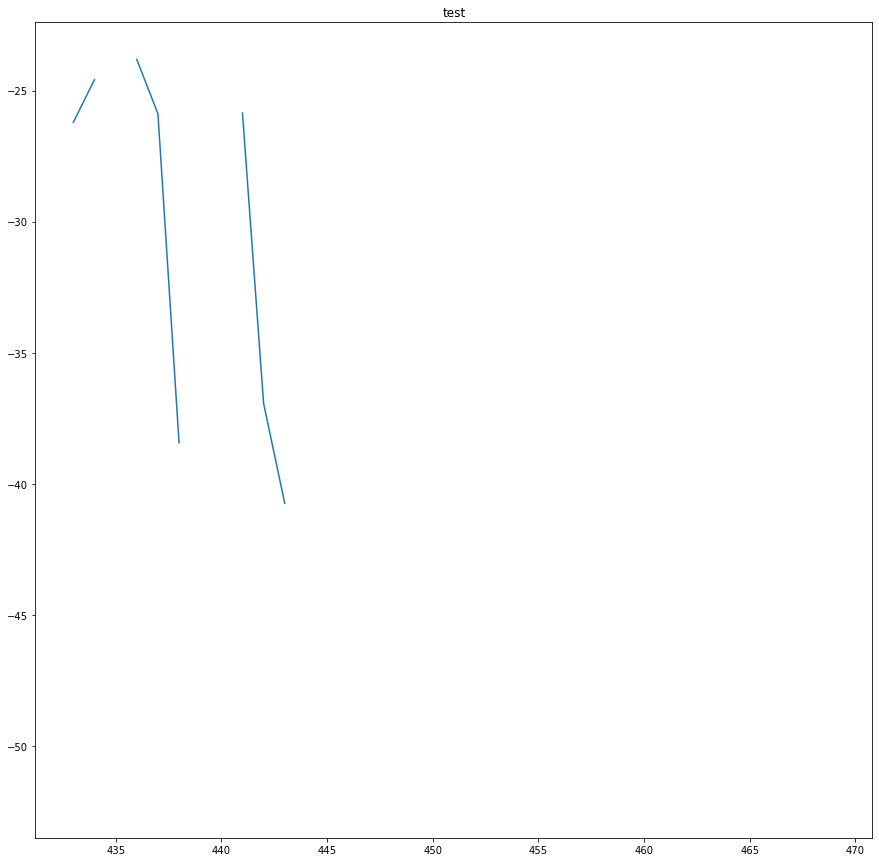

In [ ]:
def parameter_over_session():
    session = project.l_sessions[0]
    plt.figure(figsize=(15,15), facecolor='white')


    plt.plot(session.master_df.index.values[430:470], session.master_df["angle_bodyaxis_ForePawRight"].values[430:470])

    plt.ylim = (0)
    plt.xlim = (0, 50)
    plt.title("test")
    plt.show()
    plt.close()
    
parameter_over_session()

In [ ]:
def show_frame_over_pawspeed(ind):
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(8, 5, hspace=1)
    

    grid_ind = 0
    for paw in set(["HindPawRight", "HindPawLeft", "ForePawRight", "ForePawLeft"]):
        fig.add_subplot(gs[grid_ind:grid_ind+2, 0:2])
        y = project.l_sessions[0].bc.processed_df[(paw, 'speed_px_per_s')].values[0:90]
        plt.plot(project.l_sessions[0].master_df.index.values[0:90], alpha=0)
        plt.plot(y)
        plt.plot((ind, ind), (0, project.l_sessions[0].bc.processed_df[(paw, 'rolling_speed_px_per_s')].max()), c="r", lw=3)
        plt.title(paw, loc = "left") 
        grid_ind += 2
        
    plt.show()
        
    video = imageio.get_reader(project.l_sessions[0].bc.video_path,  'ffmpeg')
    frames = video.get_data(ind)
    plt.imshow(frames)
    plt.show()    
        
show_frame_over_pawspeed(7)


In [ ]:
def show_frame_over_forwardsteps(ind):
    #Ansatz: Distanz zu vorheriger Position
    #Richtung einbauen?
    step_threshold = 0.75
    fig = plt.figure(figsize=(20, 17))
    gs = fig.add_gridspec(10, 2, hspace=1)
    

    grid_ind = 0
    for paw in set(["HindPawRight", "HindPawLeft", "ForePawRight", "ForePawLeft"]):
        fig.add_subplot(gs[grid_ind:grid_ind+2, 0:2])
        l=[]
        for n in range(project.l_sessions[0].bc.processed_df.shape[0]-1):
            l.append(np.sqrt((project.l_sessions[0].bc.processed_df[(paw, 'x_norm_cm')][n]-project.l_sessions[0].bc.processed_df[(paw, 'x_norm_cm')][n+1])**2 + (project.l_sessions[0].bc.processed_df[(paw, 'y_norm_cm')][n]-project.l_sessions[0].bc.processed_df[(paw, 'y_norm_cm')][n+1])**2))

        arr = np.asarray(l)
        df=pd.DataFrame(data=arr, columns=["Distance to previous frame"])
        df["Stance/Swing"] = 0
        df.loc[df["Distance to previous frame"] < step_threshold, "Stance/Swing"] = 1
        df.loc[df["Distance to previous frame"] > step_threshold, "Stance/Swing"] = 0
        x = project.l_sessions[0].master_df.index.values[0:project.l_sessions[0].master_df.index.shape[0]-1]
        y = df["Stance/Swing"]
        plt.step(x, y)
        plt.yticks([0, 1], ["Swing", "Stance"])
        plt.title(paw, loc = "left")        
        grid_ind += 2
        plt.plot((ind, ind), (0, 1), c="r", lw=3, alpha=0.5)
        
    fig.add_subplot(gs[8:10, 0:2])
    for n in range(5):
        if ((ind-n)<0) ==False & ((ind+n)>project.l_sessions[0].master_df.index.shape[0]-1) ==False:
            y = [project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].values[ind-n], project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].values[ind+n]]
            x = [project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].values[ind-n], project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].values[ind+n]]
            alpha = 1-0.2*n
            c = "green"
            if n == 0:
                c = "blue"
            plt.scatter(x, y, alpha=alpha, c=c, s=20)
                                                                                
    plt.scatter((project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].min(), project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].max()), (project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].min(), project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].max()), alpha=0)
    plt.title("Coordinates CenterofGravity", loc = "left")   
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 17))
    video = imageio.get_reader(project.l_sessions[0].bc.video_path,  'ffmpeg')
    frames = video.get_data(ind)
    plt.imshow(frames)
    plt.show()

frame_slider=widgets.IntSlider(min=0, max=800, continuous_update = False, layout=widgets.Layout(width="800px"))
w = interactive(show_frame_over_forwardsteps, ind=frame_slider)
box=VBox([w])
display(box)

In [ ]:
import statistics

def show_frame_over_forwardsteps(ind):
    #Ansatz: rolling speed
    framerate = 30
    speed_threshold = {"ForePawRight": 150, "ForePawLeft": 150, "HindPawRight": 100, "HindPawLeft": 120}
    fig = plt.figure(figsize=(20, 17))
    gs = fig.add_gridspec(10, 2, hspace=1)
    

    grid_ind = 0
    for paw in set(["HindPawRight", "HindPawLeft", "ForePawRight", "ForePawLeft"]):
        fig.add_subplot(gs[grid_ind:grid_ind+2, 0:2])
        
        df=project.l_sessions[0].bc.processed_df[paw].copy()
        df["Stance/Swing"] = np.NaN
        df.loc[df["rolling_speed_px_per_s"] < speed_threshold[paw], "Stance/Swing"] = 1
        df.loc[df["rolling_speed_px_per_s"] > speed_threshold[paw], "Stance/Swing"] = 0
        x = project.l_sessions[0].master_df.index.values[0:project.l_sessions[0].master_df.index.shape[0]]
        y = df["Stance/Swing"]
        plt.step(x, y)
        plt.yticks([0, 1], ["Swing", "Stance"])
        plt.title(paw, loc = "left")   
        ran = [0]*project.l_sessions[0].master_df.shape[0]
        plt.plot(ran, alpha=0)
        grid_ind += 2
        plt.plot((ind, ind), (0, 1), c="r", lw=3, alpha=0.5)
        
        n_steps = [n for n in range(1, 800) if (df["Stance/Swing"].iloc[n] == 0) & (df["Stance/Swing"].iloc[n-1] == 1)]
        l_step_dist =[]
        l_step_dur=[]
        for step in n_steps:
            step_start_ind = step
            n = step_start_ind
            b = 0
            while df["Stance/Swing"].iloc[n] !=1:
                n += 1
                if n > df["Stance/Swing"].shape[0]:
                    break

                if df["Stance/Swing"].iloc[n] == np.NaN:
                    b+=1
                if b >= 3:
                    break
            step_end_ind = n
            step_start_position = (df["x_norm_cm"].iloc[(step_start_ind-1)], df["y_norm_cm"].iloc[step_start_ind-1])
            step_end_position = (df["x_norm_cm"].iloc[n], df["y_norm_cm"].iloc[n])
            step_distance = math.sqrt((step_start_position[0]-step_end_position[0])**2 + (step_start_position[1]-step_end_position[1])**2)
            step_y_dist = abs(step_start_position[1]-step_end_position[1])
            step_duration = (step_end_ind - step_start_ind)/framerate
            l_step_dist.append(step_distance)
            l_step_dur.append(step_duration)
        mean_step_distance = sum(l_step_dist)/len(n_steps)
        mean_step_duration = sum(l_step_dur)/len(n_steps)
        step_length_variability = statistics.stdev(l_step_dist)
        display("number of steps " + paw + ": " + str(len(n_steps)))
        display("Mean step distance: " + str(mean_step_distance) + "   Mean step duration: " + str(mean_step_duration))
        #Stride vs step!
        display("Step length standard deviation: " + str(step_length_variability))
        #Gait symmetry:
        #implement in code
        #plot over sessions

    fig.add_subplot(gs[8:10, 0:2])
    for n in range(5):
        if ((ind-n)<0) ==False & ((ind+n)>project.l_sessions[0].master_df.index.shape[0]-1) ==False:
            y = [project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].values[ind-n], project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].values[ind+n]]
            x = [project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].values[ind-n], project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].values[ind+n]]
            alpha = 1-0.2*n
            c = "green"
            if n == 0:
                c = "blue"
            plt.scatter(x, y, alpha=alpha, c=c, s=20)
                                                                                
    plt.scatter((project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].min(), project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'y_norm_cm')].max()), (project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].min(), project.l_sessions[0].bc.processed_df[("CenterOfGravity", 'x_norm_cm')].max()), alpha=0)
    plt.title("Coordinates CenterofGravity", loc = "left")   
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 17))
    video = imageio.get_reader(project.l_sessions[0].bc.video_path,  'ffmpeg')
    frames = video.get_data(ind)
    plt.imshow(frames)
    plt.show()

frame_slider=widgets.IntSlider(min=0, max=800, continuous_update = False, layout=widgets.Layout(width="800px"))
w = interactive(show_frame_over_forwardsteps, ind=frame_slider)
box=VBox([w])
display(box)

In [ ]:
def get_static_and_dynamic_data(ind):
    fig, ax = plt.subplots(figsize=(10, 17))
    display("Static data:")
    #avg degree paw bodyaxis
    for paw in set(["HindPawRight", "HindPawLeft", "ForePawRight", "ForePawLeft"]):
        mean_paw_angle = project.l_sessions[0].master_df["angle_bodyaxis_" + paw].mean()
        display("Average Angle Bodyaxis-" + paw + ": " + str(mean_paw_angle))
    
    display("Dynamic data:")
    for paw in set(["HindPawRight", "HindPawLeft", "ForePawRight", "ForePawLeft"]):
        paw_angle = project.l_sessions[0].master_df["angle_bodyaxis_" + paw].iloc[ind]
        display("Angle Bodyaxis-" + paw + ": " + str(paw_angle))
        plt.scatter(project.l_sessions[0].bc.processed_df[(paw, "x")].iloc[ind], project.l_sessions[0].bc.processed_df[(paw, "y")].iloc[ind], c="b")
    for bodypart in set(["TailBase", "CenterOfGravity", "Snout"]):
        plt.scatter(project.l_sessions[0].bc.processed_df[(bodypart, "x")].iloc[ind], project.l_sessions[0].bc.processed_df[(bodypart, "y")].iloc[ind], c="g")
    for bodypart in set(["HindPawRightFifthFinger", "HindPawLeftFifthFinger", "ForePawRightFifthFinger", "ForePawLegtFifthFinger"]):
        plt.scatter(project.l_sessions[0].bc.processed_df[(bodypart, "x")].iloc[ind], project.l_sessions[0].bc.processed_df[(bodypart, "y")].iloc[ind], c="b")
    display("Hind Stance width: " + str(project.l_sessions[0].master_df["hind_stance"].iloc[ind]))
    display("Fore Stance width: " + str(project.l_sessions[0].master_df["fore_stance"].iloc[ind]))
    display("Current stride length: not implemented yet")
    
    video = imageio.get_reader(project.l_sessions[0].bc.video_path,  'ffmpeg')
    frames = video.get_data(ind)
    plt.imshow(frames)
    plt.show()
    
frame_slider=widgets.IntSlider(min=0, max=800, continuous_update = False, layout=widgets.Layout(width="800px"))
w = interactive(get_static_and_dynamic_data, ind=frame_slider)
box=VBox([w])
display(box)

In [ ]:
"""
angle CoG-TailBase-HindPaw
angle CoG-Snout-ForePaw
"""